In [1]:
# Import library

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

### Appunti

This is a very important stage in a data science/machine learning pipeline. It involves understanding the problem in detail by brainstorming maximum possibilities that can impact the outcome. It is done by thoroughly understanding the problem statement before looking at the data.

Below are some of the factors which I think can affect the Loan Approval (dependent variable for this loan prediction problem:

Salary: Applicants with high income should have more chances of getting approval.
Previous history: Applicants who have paid their historical debts have more chances of getting approval.
Loan amount: Less the amount higher the chances of getting approval.
Loan term: Less the time period has higher chances of ap

These are some of the factors which I think can affect the target variable, you can find many more factorsproval.

## Import data

In [3]:
# Load the datasets
train_data = pd.read_csv('Data/Loan_dataset_train.csv') # This is the portion of the dataset used to "train" or fit the model.
test_data = pd.read_csv('Data/Loan_dataset_test.csv') # This subset is reserved for evaluating the model’s performance after training.

# Let's create duplicates of the train and test datasets to ensure that any modifications won't affect the original data.
train_original_data = train_data.copy() 
test_original_data = test_data.copy()

# Display the first few rows of each dataset
print("Training Data Head:")
print(train_data.head())

print("\nTest Data Head:")
print(test_data.head())

Training Data Head:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  


## Understanding the data

In [4]:
# Data columns
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

We have 12 independent variables and 1 target variable, i.e., Loan_Status

In [5]:
# Data columns
test_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

The test dataset contains the same features as the training dataset, except for Loan_Status. The model will be trained on the training data to predict Loan_Status for the test dataset.

The description of each variable is provided below.

| Variable           | Description                                  |
|--------------------|----------------------------------------------|
| Loan_ID            | Unique Loan ID                               |
| Gender             | Male/ Female                                 |
| Married            | Applicant married (Y/N)                      |
| Dependents         | Number of dependents                         |
| Education          | Applicant Education (Graduate/Under Graduate)|
| Self_Employed      | Self employed (Y/N)                          |
| ApplicantIncome    | Applicant income                             |
| CoapplicantIncome  | Coapplicant income                           |
| LoanAmount         | Loan amount in thousands                     |
| Loan_Amount_Term   | Term of loan in months                       |
| Credit_History     | Credit history meets guidelines              |
| Property_Area      | Urban/ Semi Urban/ Rural                     |
| Loan_Status        | Loan approved (Y/N)                          |


In [6]:
# Display the data types of each variable.
train_data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

There are three data types present in our dataset:

- **object**: This format indicates categorical variables. The categorical variables in our dataset include:
  - `Loan_ID`
  - `Gender`
  - `Married`
  - `Dependents`
  - `Education`
  - `Self_Employed`
  - `Property_Area`
  - `Loan_Status`

- **int64**: This type represents integer variables. In our dataset, `ApplicantIncome` falls under this format.

- **float64**: This type includes variables with decimal values, which are also numerical. The numerical variables in this format are:
  - `CoapplicantIncome`
  - `LoanAmount`
  - `Loan_Amount_Term`
   `Credit_History`
 `Credit_History`


In [7]:
# Dataset shape
train_data.shape, test_data.shape

((614, 13), (367, 12))

We have 614 rows and 13 columns in the training dataset and 367 rows and 12 columns in the test dataset.

## Data Exploration
Expanding on the exploratory analysis will allow to better understand the data distribution, feature relationships, and key patterns.

### Univariate analysis
This part focuses on examining each feature individually, understanding the distribution of categorical and numerical variables, and identifying potential outliers.

<Axes: xlabel='Loan_Status'>

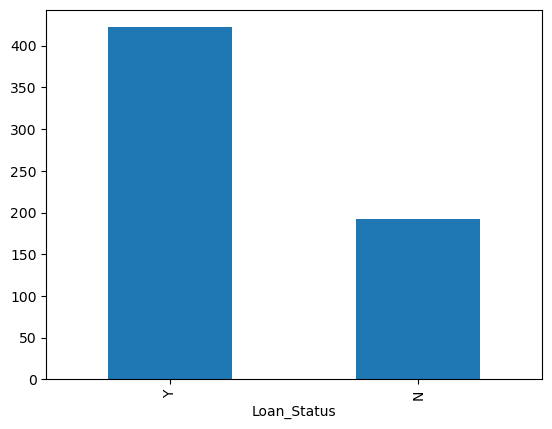

In [8]:
# Distribution of target variable (Loan_Status)
train_data['Loan_Status'].value_counts().plot.bar()

The distribution plot shows that the target variable, Loan_Status, has more approved loans (labeled as Y) than disapproved ones (labeled as N). This suggests a slight class imbalance, which might require consideration during model training to avoid bias toward the majority class.

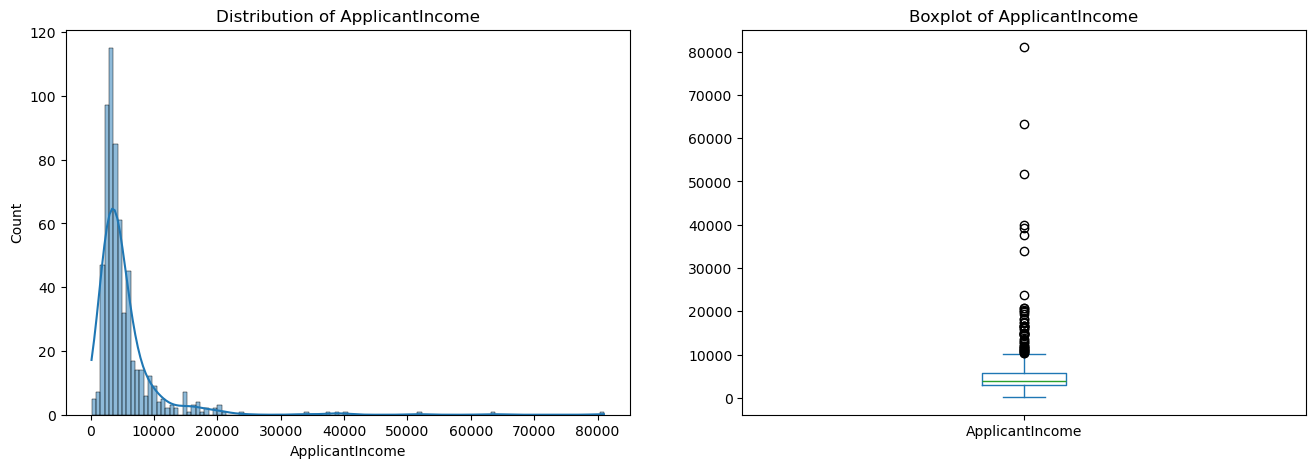

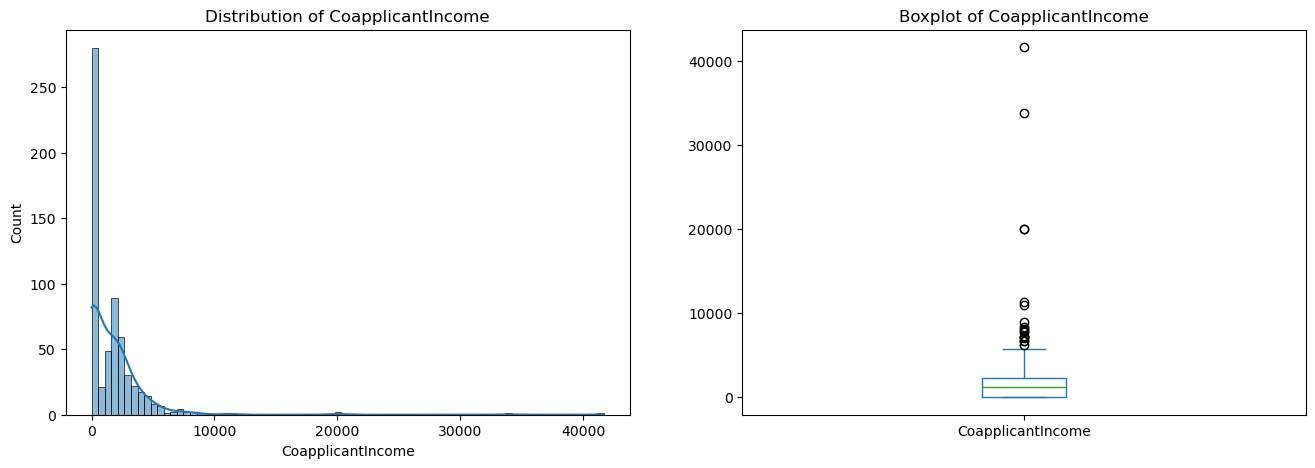

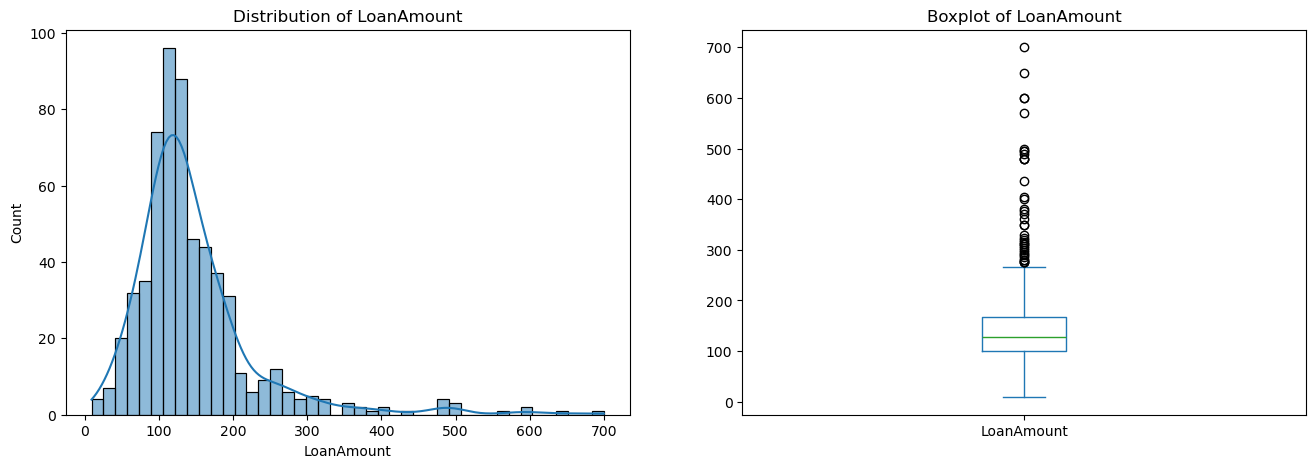

In [13]:
# Distributions of numerical features

# List of numerical columns
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'] 

# Loop through each column to create distribution and boxplots
for column in numerical_columns:
    plt.figure(figsize=(16, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[column], kde=True)  
    plt.title(f'Distribution of {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    train_data[column].plot.box()
    plt.title(f'Boxplot of {column}')
    
    plt.show()

The histograms show that the distribution of ApplicantIncome and CoapplicantIncome are right-skewed, indicating that a few applicants have significantly higher incomes than others. This skewness might necessitate scaling or transformation for more effective modeling. 
Additionally, LoanAmount also exhibits a similar right-skewed distribution.
There are also some outliers tha will be addressed  in later sections.

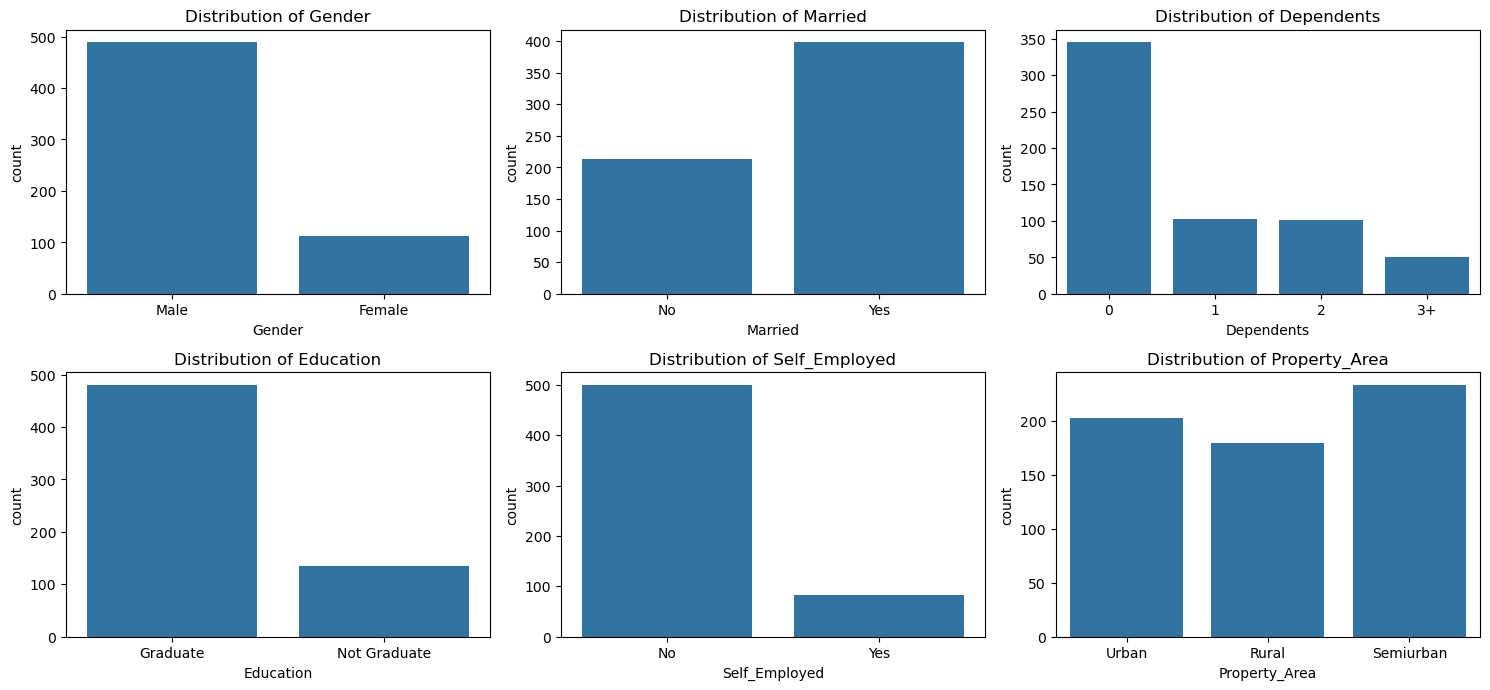

In [16]:
categorical_features = train_data.select_dtypes(include=['object']).columns.drop(['Loan_ID', 'Loan_Status'])
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_data, x=column)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

The count plots reveal key characteristics of the categorical features:

- **Gender** and **Married**: The majority of applicants are male and married.
- **Dependents**: There is a higher proportion of applicants without dependents, with fewer applicants reporting multiple dependents.
- **Education**: Most applicants are graduates.
- **Self_Employed**: Fewer applicants are self-employed, which might be a distinguishing characteristic among applicants.
- **Property_Area**: The distribution is fairly balanced across *Rural*, *Urban*, and *Semiurban* areas, potentially aiding in differentiating loan outcomes based on geographic context.

## Bivariate Analysis

Bivariate analysis explores the relationship between each feature and the target variable, allowing to examine potential correlations or patterns.
